In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 31.2 MB/s eta 0:00:00


In [ ]:
import sys
sys.path.insert(0,"/content/drive/My Drive/FYP/RNN/ConditionalRNN")

In [ ]:
import numpy as np
import pandas as pd

import os
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold,GroupKFold

import tensorflow as tf
from cond_rnn import ConditionalRNN
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
from tensorflow.keras.optimizers import Adam,Nadam
from tensorflow.keras import initializers

In [ ]:
import random
def seed_everything(seed=2020):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
seed_everything(43)

In [ ]:
NFOLD = 5
kf = KFold(n_splits=NFOLD)

In [ ]:
ROOT = "/content/drive/My Drive/FYP/RNN"

In [ ]:
tr = pd.read_csv(f"{ROOT}/train.csv")
tr.drop_duplicates(keep=False, inplace=True, subset=['Patient','Weeks'])
chunk = pd.read_csv(f"{ROOT}/test.csv")

print("add infos")
sub = pd.read_csv(f"{ROOT}/sample_submission.csv")
sub['Patient'] = sub['Patient_Week'].apply(lambda x:x.split('_')[0])
sub['Weeks'] = sub['Patient_Week'].apply(lambda x: int(x.split('_')[-1]))
sub =  sub[['Patient','Weeks','Confidence','Patient_Week']]
sub = sub.merge(chunk.drop('Weeks', axis=1), on="Patient")

add infos


In [ ]:
tr['WHERE'] = 'train'
chunk['WHERE'] = 'val'
sub['WHERE'] = 'test'
data = tr.append([chunk, sub])

<ipython-input-11-ae39faceb727>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = tr.append([chunk, sub])


In [ ]:
print(tr.shape, chunk.shape, sub.shape, data.shape)

(1535, 8) (5, 8) (730, 10) (2270, 10)


In [ ]:
data['min_week'] = data['Weeks']
data.loc[data.WHERE=='test','min_week'] = np.nan
data['min_week'] = data.groupby('Patient')['min_week'].transform('min')

In [ ]:
base = data.loc[data.Weeks == data.min_week]
base = base[['Patient','FVC']].copy()
base.columns = ['Patient','min_FVC']
base['nb'] = 1
base['nb'] = base.groupby('Patient')['nb'].transform('cumsum')
base = base[base.nb==1]
base.drop('nb', axis=1, inplace=True)

In [ ]:
data = data.merge(base, on='Patient', how='left')
data['base_week'] = data['Weeks'] - data['min_week']
del base

In [ ]:
# Create Alternate Categorical Features 
COLS = ['Sex','SmokingStatus']
FE = []
for col in COLS:
    data[col] = pd.factorize(data[col])[0]
FE.extend(COLS)
#=================
COLS = ['Sex','SmokingStatus']
# FE = []
for mod in data[col].unique():
    FE.append(mod)
    data[mod] = (data[col] == mod).astype(int)

In [ ]:
# Scale features to quantiles 
data['age'] = (data['Age'] - data['Age'].min() ) / ( data['Age'].max() - data['Age'].min() )
data['BASE'] = (data['min_FVC'] - data['min_FVC'].min() ) / ( data['min_FVC'].max() - data['min_FVC'].min() )
data['week'] = (data['base_week'] - data['base_week'].min() ) / ( data['base_week'].max() - data['base_week'].min() )
data['percent'] = (data['Percent'] - data['Percent'].min() ) / ( data['Percent'].max() - data['Percent'].min() )
FE += ['age','percent','week','BASE']

In [ ]:
tr = data.loc[data.WHERE=='train']
chunk = data.loc[data.WHERE=='val']
sub = data.loc[data.WHERE=='test']
del data

In [ ]:
print(tr.shape, chunk.shape, sub.shape)

(1535, 20) (5, 20) (730, 20)


In [ ]:
tr[FE]

,Sex,SmokingStatus,0,1,2,age,percent,week,BASE
0,0,0,1,0,0,0.769231,0.236393,0.179012,0.241456
1,0,0,1,0,0,0.769231,0.215941,0.234568,0.241456
2,0,0,1,0,0,0.769231,0.184960,0.246914,0.241456
3,0,0,1,0,0,0.769231,0.201767,0.259259,0.241456
4,0,0,1,0,0,0.769231,0.186580,0.271605,0.241456
...,...,...,...,...,...,...,...,...,...
1530,0,1,0,1,0,0.615385,0.303514,0.259259,0.354755
1531,0,1,0,1,0,0.615385,0.356076,0.296296,0.354755
1532,0,1,0,1,0,0.615385,0.342244,0.370370,0.354755
1533,0,1,0,1,0,0.615385,0.355484,0.444444,0.354755


In [ ]:
# Get Features
# groups = tr['Patient']
y = tr['FVC'].values
z = tr[FE].values
ze = sub[FE].values
# --------------------------------------------------------
#Create oof and prediction arrays
pe = np.zeros((ze.shape[0], 3))
pred = np.zeros((z.shape[0], 3))
# --------------------------------------------------------
#Split the train set's categorical and measurement features
train_categories = z[:,0:5]#normal shape
train_measurements = z[:,5:].reshape(z.shape[0],1,-1)#[batch, timesteps, features]
# --------------------------------------------------------
#Split the test set's categorical and measurement features
test_categories = ze[:,0:5] #normal shape
test_measurements = ze[:,5:].reshape(ze.shape[0],1,-1)#[batch, timesteps, features]

In [ ]:
C1, C2 = tf.constant(70, dtype='float32'), tf.constant(1000, dtype="float32")
#=============================#
def score(y_true, y_pred):
    tf.dtypes.cast(y_true, tf.float32)
    tf.dtypes.cast(y_pred, tf.float32)
    
    sigma = y_pred[:, 2] - y_pred[:, 0]
    fvc_pred = y_pred[:, 1]
    
    #sigma_clip = sigma + C1
    sigma_clip = tf.maximum(sigma, C1)
    # print(y_true[:, 0])
    # print(fvc_pred)
    y_true=float(y_true[:, 0])
    delta = tf.abs(y_true - fvc_pred)
    # print("hi")
    delta = tf.minimum(delta, C2)
    sq2 = tf.sqrt( tf.dtypes.cast(2, dtype=tf.float32) )
    metric = (delta / sigma_clip)*sq2 + tf.math.log(sigma_clip* sq2)
    return K.mean(metric)
#============================#
def qloss(y_true, y_pred):
    # Pinball loss for multiple quantiles
    qs = [0.2, 0.50, 0.8]
    q = tf.constant(np.array([qs]), dtype=tf.float32)
    y_true=float(y_true)
    e = y_true - y_pred
    # print("hi")
   
    v = tf.maximum(q*e, (q-1)*e)
    return K.mean(v)
#=============================#
def mloss(_lambda):
    def loss(y_true, y_pred):
        # print(y_pred)
        return _lambda * qloss(y_true, y_pred) + (1 - _lambda)*score(y_true, y_pred)
    return loss

In [ ]:
class MySimpleModel(tf.keras.Model):
    def __init__(self):
        super(MySimpleModel, self).__init__()
        self.cond = ConditionalRNN(100, cell='LSTM', dtype=tf.float32)
        self.x = L.Dense(100, activation='elu',kernel_initializer='he_uniform', name="d2")
        self.p1 = L.Dense(3, activation="linear", name="p1")
        self.p2 = L.Dense(3, activation="relu",kernel_initializer='he_uniform', name="p2")
        self.preds = L.Lambda(lambda x: x[0] + tf.cumsum(x[1], axis=1), 
                         name="preds")

    def call(self, inputs, **kwargs):
        o = self.cond(inputs)
        o = self.x(o)
        linear = self.p1(o)
        relu = self.p2(o)
        o = self.preds([linear,relu])
        return o

In [ ]:
net = MySimpleModel()
net.call([train_measurements,train_categories])
net.compile(optimizer='adam', loss=mloss(0.8), metrics=[score])
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
# Just double checking model inpute
print(train_measurements.shape,train_categories.shape)

(1535, 1, 4) (1535, 5)


In [ ]:
# Setting jit/xla for greater efficiency 
tf.keras.backend.clear_session()
tf.config.optimizer.set_jit(True)

In [ ]:
%%time
cnt = 0
BatchSize = 200
for tr_idx, val_idx in kf.split(z):
    cnt += 1
    
    print(f"FOLD {cnt}")
#     with tf.device('/gpu:0'):
    net.fit([train_measurements[tr_idx,:,:],train_categories[tr_idx,:]], pd.Series(y[tr_idx].astype(float).flatten()), batch_size=BatchSize, epochs=800, 
    validation_data=([train_measurements[val_idx,:,:],train_categories[val_idx,:]], pd.Series(y[val_idx].astype(float).flatten())), verbose=0) #
    print("train", net.evaluate([train_measurements[tr_idx,:,:],train_categories[tr_idx,:]], y[tr_idx], verbose=0, batch_size=BatchSize))
    print("val", net.evaluate([train_measurements[val_idx,:,:],train_categories[val_idx,:]], y[val_idx], verbose=0, batch_size=BatchSize))
    print("predict val...")
    pred[val_idx] = net.predict([train_measurements[val_idx,:,:],train_categories[val_idx,:]], batch_size=BatchSize, verbose=0)
    print("predict test...")
    pe += net.predict([test_measurements,test_categories], batch_size=BatchSize, verbose=0) / NFOLD
# ==============

FOLD 1
train [39.79130935668945, 6.564958095550537]
val [50.899295806884766, 6.720841407775879]
predict val...
predict test...
FOLD 2
train [39.78903579711914, 6.567624092102051]
val [46.438720703125, 6.644113063812256]
predict val...
predict test...
FOLD 3
train [38.27469253540039, 6.509463310241699]
val [49.41466522216797, 6.718761444091797]
predict val...
predict test...
FOLD 4
train [38.280540466308594, 6.528077125549316]
val [43.04805374145508, 6.627887725830078]
predict val...
predict test...
FOLD 5
train [35.6562614440918, 6.358656883239746]
val [48.156734466552734, 6.73057222366333]
predict val...
predict test...
CPU times: user 7min 15s, sys: 16.6 s, total: 7min 32s
Wall time: 6min 42s


In [ ]:
sigma_opt = mean_absolute_error(y, pred[:,1])
unc = pred[:,2] - pred[:, 0]
sigma_mean = np.mean(unc)
print(sigma_opt, sigma_mean)

138.5999644524888 235.55480304929256


Best Quantile: 0.44
Best MAE of Optimized Quantile: 138.0060035420272
Baseline MAE: 138.5999644524888


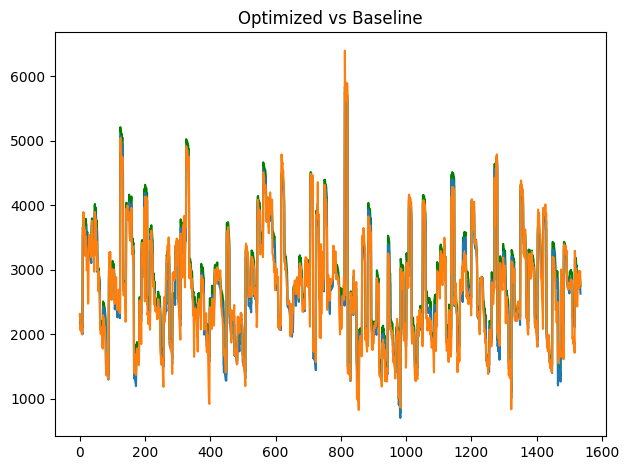

In [ ]:
increment = 0.001
error = []
for i in np.arange(0,1,increment):
    quant_5 = np.quantile(pred,i,axis=1)
#     print(mean_absolute_error(y,quant_5))
    error.append(mean_absolute_error(y,quant_5))
    
print('Best Quantile:',np.arange(0,1,increment)[np.argmin(error)])
print('Best MAE of Optimized Quantile:',error[np.argmin(error)])
print('Baseline MAE:', mean_absolute_error(y,pred[:,1]))
# Optimized vs Baseline Graphs
plt.plot(quant_5,c='g')
plt.title('Optimized vs Baseline')
plt.plot(pred[:,1])
plt.plot(y)
plt.tight_layout()
plt.show()

In [ ]:
import math
import scipy as sp
from functools import partial
scoring_df = pd.DataFrame(z)
scoring_df['FVC_pred'] = pred[:,1]
scoring_df['FVC'] = y
# baseline score
scoring_df['Confidence'] = 100
scoring_df['sigma_clipped'] = scoring_df['Confidence'].apply(lambda x: max(x, 70))
scoring_df['diff'] = abs(scoring_df['FVC'] - scoring_df['FVC_pred'])
scoring_df['delta'] = scoring_df['diff'].apply(lambda x: min(x, 1000))
scoring_df['score'] = -math.sqrt(2)*scoring_df['delta']/scoring_df['sigma_clipped'] - np.log(math.sqrt(2)*scoring_df['sigma_clipped'])
score = scoring_df['score'].mean()
print(score)

def loss_func(weight, row):
    confidence = weight
    sigma_clipped = max(confidence, 70)
    diff = abs(row['FVC'] - row['FVC_pred'])
    delta = min(diff, 1000)
    score = -math.sqrt(2)*delta/sigma_clipped - np.log(math.sqrt(2)*sigma_clipped)
    return -score

results = []
tk0 = tqdm(scoring_df.iterrows(), total=len(scoring_df))
for _, row in tk0:
    loss_partial = partial(loss_func, row=row)
    weight = [100]
    result = sp.optimize.minimize(loss_partial, weight, method='SLSQP')
    x = result['x']
    results.append(x[0])

# optimized score
scoring_df['Confidence'] = results
scoring_df['sigma_clipped'] = scoring_df['Confidence'].apply(lambda x: max(x, 70))
scoring_df['diff'] = abs(scoring_df['FVC'] - scoring_df['FVC_pred'])
scoring_df['delta'] = scoring_df['diff'].apply(lambda x: min(x, 1000))
scoring_df['score'] = -math.sqrt(2)*scoring_df['delta']/scoring_df['sigma_clipped'] - np.log(math.sqrt(2)*scoring_df['sigma_clipped'])
score = scoring_df['score'].mean()
print(score)

-6.911665540602519


100%|██████████| 1535/1535 [00:09<00:00, 167.65it/s]

-6.28066248423373


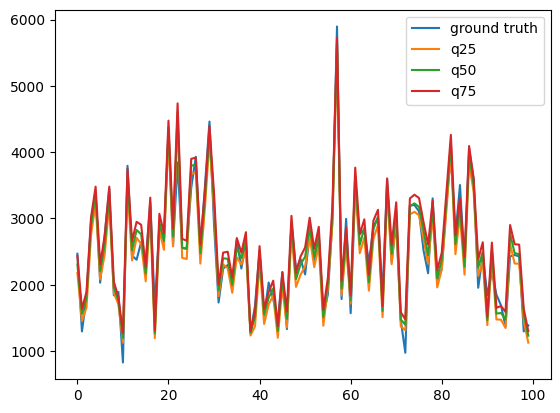

In [ ]:
idxs = np.random.randint(0, y.shape[0], 100)
plt.plot(y[idxs], label="ground truth")
plt.plot(pred[idxs, 0], label="q25")
plt.plot(pred[idxs, 1], label="q50")
plt.plot(pred[idxs, 2], label="q75")
plt.legend(loc="best")
plt.show()

In [ ]:
print(unc.min(), unc.mean(), unc.max(), (unc>=0).mean())

65.94677734375 235.55480304929256 293.119873046875 1.0


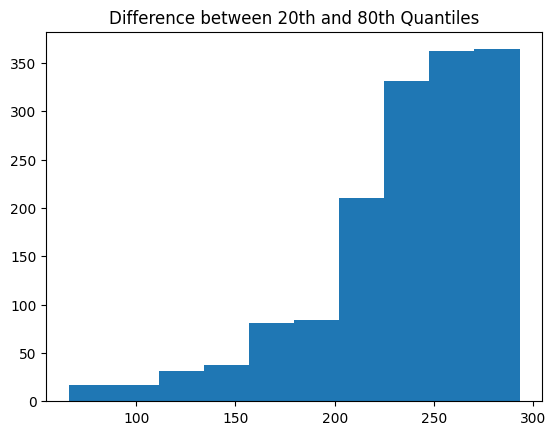

In [ ]:
plt.hist(unc)
plt.title("Difference between 20th and 80th Quantiles")
plt.show()

In [ ]:
sub['FVC1'] = pe[:,1]
sub['Confidence1'] = (pe[:, 2] - pe[:, 0])

In [ ]:
subm = sub[['Patient_Week','FVC','Confidence','FVC1','Confidence1']].copy()

In [ ]:
subm.loc[~subm.FVC1.isnull()].head(10)

,Patient_Week,FVC,Confidence,FVC1,Confidence1
1540,ID00419637202311204720264_-12,3020,100.0,2877.337646,270.157532
1541,ID00419637202311204720264_-11,3020,100.0,2874.982544,270.256348
1542,ID00419637202311204720264_-10,3020,100.0,2872.632935,270.354858
1543,ID00419637202311204720264_-9,3020,100.0,2870.288757,270.453003
1544,ID00419637202311204720264_-8,3020,100.0,2867.950073,270.550842
1545,ID00419637202311204720264_-7,3020,100.0,2865.616882,270.648376
1546,ID00419637202311204720264_-6,3020,100.0,2863.288635,270.745544
1547,ID00419637202311204720264_-5,3020,100.0,2860.966187,270.842285
1548,ID00419637202311204720264_-4,3020,100.0,2858.649231,270.938843
1549,ID00419637202311204720264_-3,3020,100.0,2856.337463,271.034912


In [ ]:
subm.loc[~subm.FVC1.isnull(),'FVC'] = subm.loc[~subm.FVC1.isnull(),'FVC1']
if sigma_mean<70:
    subm['Confidence'] = sigma_opt
else:
    subm.loc[~subm.FVC1.isnull(),'Confidence'] = subm.loc[~subm.FVC1.isnull(),'Confidence1']

In [ ]:
subm.head()

,Patient_Week,FVC,Confidence,FVC1,Confidence1
1540,ID00419637202311204720264_-12,2877.337646,270.157532,2877.337646,270.157532
1541,ID00419637202311204720264_-11,2874.982544,270.256348,2874.982544,270.256348
1542,ID00419637202311204720264_-10,2872.632935,270.354858,2872.632935,270.354858
1543,ID00419637202311204720264_-9,2870.288757,270.453003,2870.288757,270.453003
1544,ID00419637202311204720264_-8,2867.950073,270.550842,2867.950073,270.550842


In [ ]:
subm.describe().T

,count,mean,std,min,25%,50%,75%,max
FVC,730.0,2679.817359,309.181283,2047.543732,2615.779694,2723.714661,2847.552246,3239.399719
Confidence,730.0,266.790358,7.860069,248.295166,261.353447,266.482620,273.541893,280.773285
FVC1,730.0,2679.817359,309.181283,2047.543732,2615.779694,2723.714661,2847.552246,3239.399719
Confidence1,730.0,266.790358,7.860069,248.295166,261.353447,266.482620,273.541893,280.773285


In [ ]:
subm["Confidence"]

1540    270.157532
1541    270.256348
1542    270.354858
1543    270.453003
1544    270.550842
           ...    
2265    262.125031
2266    262.187317
2267    262.248993
2268    262.310516
2269    262.371582
Name: Confidence, Length: 730, dtype: float64

In [ ]:
subm[["Patient_Week","FVC","Confidence"]].to_csv(ROOT+"/submission_RNN.csv", index=False)